# Predictions for the MBTA #

## Motivation ##

So as to provide the most accurate prediction of daily ridership (number of entries) per station, it is crucial to come up with the right set of features and methods for model selection. Intuitively, we know that the recent past goes a long way toward predicting the near future, and we augmented that insight with data about weather patterns and sporting events in hopes of capturing their variability in our models and determining the incremental benefit each of these provide. Python’s toolset allows us to easily fit and tune multiple regression models which permits us to select the model for each T station that best predicts station entries for each day, when evaluated against held-out testing data.

To provide final evaluation of our models, we compared them to “naïve” predictions of ridership based on unweighted averages of recent weeks’ ridership. This demonstrates the value that machine learning techniques add above simple intuition.


## Methodology ##

### Setup ###

In [1]:
# Libraries.
import os
import itertools

import matplotlib, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import cross_validation, grid_search
from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble

sns.set_style("whitegrid")
sns.set_context("paper")
% matplotlib inline

In [176]:
#define colors used in team palette
blue= (0.44999999999999996, 0.7123853211009172, 1.0)
orange= (1.0, 0.6640217391304348, 0.44999999999999996)
green= (0.4010294117647058, 0.8911764705882352, 0.5056675479180436)
red= (1.0, 0.4772277227722773, 0.44999999999999996)

datadir = 'C:\Users\Lyla\Documents\HARVARD\_SPRING2015\AC297r\project\data'

### Data Wrangling ###

#### MBTA ####

The MBTA provided us with entry data for each station at 15 minute intervals. After some wrangling, our base data set was composed of a ***stations*** data set and a ***gate count*** data set.

##### Stations #####

The station data set contained basic information for each station. One row corresponded to one station. Some of the data, in particular the latitude and longitude, was scraped from the web.

- ***stationid***: The unique identifier for the station.
- ***name***: The full name of the station station.
- ***line_1***: The primary line of the station (red/green/blue/orange).
- ***line_2***: The secondary line of the station (red/green/blue/orange). Only a few stations, such as park street (green/red line), had a value for this field.
- ***lat***: The latitude of the station.
- ***lon***: The longitude of the station.

In [2]:
stations = pd.read_csv(datadir + '\\stations.csv', low_memory=False)
stations.head()

stationid           name line_1 line_2        lat        lon
0       1002  Andrew Square    Red    NaN  42.329550 -71.056960
1       1004     JFK/U Mass    Red    NaN  42.321438 -71.052393
2       1005   North Quincy    Red    NaN  42.274816 -71.029176
3       1006      Wollaston    Red    NaN  42.265615 -71.019402
4       1007  Quincy Center    Red    NaN  42.250879 -71.004798

##### Gate Count #####

The gate count data set contained basic information for entries at each station. One row corresponded to the number of entries at a particular 15 minute interval for a station.

- ***locationid***: The unique identifier for the station.
- ***entries***: The number of entries for 15 minute interval.
- ***exits***: The number of exits for the 15 minute interval (NOT USED - exists are unreliable due to the nature of the system).
- ***service_day***: The actual day the service started (services on weekends can run into the next day).
- ***service_datetime***: The 15 minute interval where the entries/exists were aggregated.

In [26]:
gatecounts = pd.read_csv(datadir + '\\gatecounts.csv', low_memory=False)
gatecounts.service_datetime = pd.to_datetime(gatecounts.service_datetime)
gatecounts.service_day = pd.to_datetime(gatecounts.service_day)
gatecounts.head()

locationid  entries  exits          service_day     service_datetime
0        1002        0      1  2013-01-01 00:00:00  2013-01-01 03:00:00
1        1002        1      0  2013-01-01 00:00:00  2013-01-01 05:00:00
2        1002        2      0  2013-01-01 00:00:00  2013-01-01 05:15:00
3        1002        3      0  2013-01-01 00:00:00  2013-01-01 05:30:00
4        1002        6      0  2013-01-01 00:00:00  2013-01-01 05:45:00

#### Weather ####

The weather data was obtained by scraping the [wunderground](http://www.wunderground.com/) API. Each row corresponded to the weather for a single day in Boston. A sample of the data is provided below. The most important feature was the "snow_fall" column, which was the recorded snow fall for that day.

In [5]:
weather = pd.read_csv(datadir + '\\weather.csv', low_memory=False)
weather.head()

date  fog  hail  rain  snow  temp_min  temp_max  temp_mean  \
0  2012-01-01 00:00:00    0     0     1     0        39        52         46   
1  2012-01-02 00:00:00    0     0     1     0        34        50         42   
2  2012-01-03 00:00:00    0     0     0     0        14        35         25   
3  2012-01-04 00:00:00    0     0     0     0        10        28         19   
4  2012-01-05 00:00:00    0     0     0     0        25        39         32   

   rain_fall  snow_fall  wind_speed  vis_min  vis_max  vis_mean  
0       0.01          0           9        9       10        10  
1       0.01          0          14       10       10        10  
2       0.00          0          15       10       10        10  
3       0.00          0          12       10       10        10  
4       0.00          0          12       10       10        10

#### Game Days ####

The game day data for Red Sox games was scraped directly from their website while the game day data for the Celtics and Bruines game was scraped from ESPN. Each row corresponded to a day in which a game (or games) occurred. A sample of the data is provided below. The most important features for daily prediction purposes were:

- ***bruins_game***: Binary column representing if a Bruins game occurred on this day.
- ***celtics_game***: Binary column representing if a Celtics game occurred on this day.
- ***sox_game***: Binary column representing if a Red Sox game occurred on this day.

In [6]:
gamedays = pd.read_csv(datadir + '\\game_days.csv', low_memory=False)
gamedays.head()

date  weekday  bruins_playoff bruins_opponent bruins_time  \
0  2012-04-13        4             NaN             NaN         NaN   
1  2012-04-14        5             NaN             NaN         NaN   
2  2012-04-15        6             NaN             NaN         NaN   
3  2012-04-16        0             NaN             NaN         NaN   
4  2012-04-17        1             NaN             NaN         NaN   

   celtics_playoff celtics_opponent celtics_time  sox_time sox_opponent  \
0              NaN              NaN          NaN  14:05:00         Rays   
1              NaN              NaN          NaN  16:05:00         Rays   
2              NaN              NaN          NaN  13:35:00         Rays   
3              NaN              NaN          NaN  11:05:00         Rays   
4              NaN              NaN          NaN  19:10:00      Rangers   

      ...      sox_sat_early  sox_sat_late  sox_sun_early  sox_sun_late  \
0     ...                  0             0              0             0   
1     ...                  1             0              0             0   
2     ...                  0             0              1             0   
3     ...                  0             0              0             0   
4     ...                  0             0              0             0   

   sox_mon_thu_early  sox_mon_thu_late  sox_mon_fri_early  sox_mon_fri_late  \
0                  0                 0                  1                 0   
1                  0                 0                  0                 0   
2                  0                 0                  0                 0   
3                  1                 0                  1                 0   
4                  0                 1                  0                 1   

   sox_fri_sat_early  sox_fri_sat_late  
0                  1                 0  
1                  1                 0  
2                  0                 0  
3                  0                 0  
4                  0                 0  

[5 rows x 110 columns]

#### Daily Data ####

The daily data set was an aggregation of entries per day for each station, with a few additional features. Sparing the details on how we generated these additional features (please refer to the ***features*** section of our repository), some important ones to recognize are:

- ***entries_weeks_ago_1***: The number of entries for this station on the same day one week ago.
- ***snow_fall***: The amount of snow the fell for that day, in inches.
- ***snow_accum***: The amount of snow accumulated up to the current day. The snow accumulation was calculated using a quasi-linear decay function based on the snow fall of the previous two weeks.
- ***dist_to_center***: The distance (in kilometers) to the center of the city (city hall).

#### Daily Data w/o Holidays ####

After some thorough analysis, we decided that "holidays" had no consistent pattern. We decided to consider them "extreme outliers" and removed them from our base data set (future analysis would be necessary for holidays). The "holidays" we removed were:

- New Years Eve
- New Years Day
- Boston Marathon
- Fourth of July
- Boston Move Out Day (September 1st)
- Thanksgiving
- Black Friday
- Christmas Week (12/25, 12/26, 12/27).

#### Daily Data w/o Weekends ####

After some thorough analysis, we decided that weekends and weekdays had two completely seperate patterns. We wanted to assist the MBTA in the greatest way possible and concentrated on weekdays, removing weekends from our base data set (future analysis would be necessary for weekends).

#### Final Data ####

Our final data set consisted of daily entries for each station, exluding holidays and weekends, with the additional weather and game features.

In [8]:
data = pd.read_csv(datadir + '\\mbta_daily_weather_games_noholidays_weekdays.csv', low_memory=False)
print("Rows: " + str(data.shape[0]))
print("Cols: " + str(data.shape[1]))
data = data.reset_index(drop=True)
data.head()

Rows: 31501
Cols: 50


locationid          service_day  entries           name line_1 line_2  \
0        1002  2013-01-03 00:00:00     5733  Andrew Square    Red    NaN   
1        1004  2013-01-03 00:00:00     5842     JFK/U Mass    Red    NaN   
2        1005  2013-01-03 00:00:00     6139   North Quincy    Red    NaN   
3        1006  2013-01-03 00:00:00     4028      Wollaston    Red    NaN   
4        1007  2013-01-03 00:00:00     7331  Quincy Center    Red    NaN   

         lat        lon     service_datetime  fog ...   snow_fall_predict  \
0  42.329550 -71.056960  2013-01-03 05:00:00    0 ...                   0   
1  42.321438 -71.052393  2013-01-03 04:45:00    0 ...                   0   
2  42.274816 -71.029176  2013-01-03 03:15:00    0 ...                   0   
3  42.265615 -71.019402  2013-01-03 05:00:00    0 ...                   0   
4  42.250879 -71.004798  2013-01-03 04:30:00    0 ...                   0   

   snow_accum  snow_accum_predict  dist_to_center  entries_weeks_ago_1  \
0           0                   0        3.404767                  NaN   
1           0                   0        4.328881                  NaN   
2           0                   0        9.777437                  NaN   
3           0                   0       10.976943                  NaN   
4           0                   0       12.909591                  NaN   

   entries_weeks_ago_2  entries_weeks_ago_3  bruins_game  celtics_game  \
0                  NaN                  NaN            0             0   
1                  NaN                  NaN            0             0   
2                  NaN                  NaN            0             0   
3                  NaN                  NaN            0             0   
4                  NaN                  NaN            0             0   

   sox_game  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 50 columns]

##  Prediction ##

### Introduction ###

Changes in the accuracy of entry predictions are one way of meauring the accuracy of a prediction. To do so, we can add target "features" (or predictors) to a basic model (Linear Regression) and check for a reduction in the overall percent error of our predictions for each station. We can define percent error for each station as:

$$ \ Station \ Error = \frac{\sum^n_i{|entries_{predicted} - entries_{actual}|}}{\sum^n_i{entries_{actual}}} $$

### Method Definitions ###

The following methods are used to help us generate a prediction model and determine the percent error for each station.

In [50]:
"""
Generates a prediction model for a given station with desired features.

This will return the best model based on 10 fold cross-validation with an 70/30 train/test split.

In addition, this will return the mean absolute error for all the entries in the test set, and any outliers
based on a given absolute error threshold.

Key arguments:

  station    -- The station to train on.
  cols       -- The columns in the station data frame that are considered features.
  predictor  -- The predictor to use (sklearn predictor)
  parameters -- The parameters for the predictor.
  rstate     -- The random state to use for the train/test split.

"""
def predict(station, features, predictor, parameters, rstate):
    # Copy the station so we don't manipulate the original.
    station = station.copy()
    
    # Get the columns of the dataframe.
    all_cols = list(station.columns)
    
    # Determine the indices of the columns.
    y_col_indices = [0] + list(np.where([col == 'entries' for col in all_cols])[0] + 1)
    x_col_indices = [0] + list(np.where([col in features for col in all_cols])[0] + 1)
    
    # Make sure none of the predictor fields are null.
    for col in features:
        station = station[pd.notnull(station[col])]
    
    # Remove any entries where no one was there (probably closed) or the entries appears to be
    #  extremely low (less than 1% of the mean).
    # We assume that any entries with less than 1% of the normal entries is having serious issues.
    min_entries = np.mean(station['entries']) * .005
    station = station[station['entries'] > min_entries]
    
    # Reset the station indices, we have to reset twice so the matrix values gets the index column.
    station = station.reset_index()
    station.drop('index', axis=1, inplace=True)
    station = station.reset_index()
    
    # Get the dataframe as a matrix where the first column is the index.
    matrix = station.values
    
    # Slice so the y only contains 2 column (index, entries)
    #  and the x is a matrix that contains the index and all the predictors.
    y = matrix[:,y_col_indices]
    x = matrix[:,x_col_indices]
    
    # Split the data set into a train and test.
    x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.3, random_state=rstate)
    
    # Convert the train and test sets into a format sklean fit() expects.
    x_train_fit = np.matrix(x_train[:,1:], dtype=np.float32)
    y_train_fit = np.array([v[0] for v in y_train[:,1:]], dtype=np.uint16)
    
    x_test_fit = np.matrix(x_test[:,1:], dtype=np.float32)
    y_test_fit = np.array([v[0] for v in y_test[:,1:]], dtype=np.uint16)
    
    # Train using a grid search based on the parameters provided.
    clf = grid_search.GridSearchCV(predictor, parameters, scoring='mean_squared_error', cv=10)
    clf.fit(x_train_fit, y_train_fit)
    
    # Determine what the best model was.
    model = clf.best_estimator_
    
    # Find the train/test data sets in the original station data frame.
    train_results = station.iloc[y_train[:,0]]
    test_results = station.iloc[y_test[:,0]]
    
    # Predict using the train/test set.
    train_results['prediction'] = model.predict(x_train_fit)
    test_results['prediction'] = model.predict(x_test_fit)
    
    # Determine the percent errors.
    train_results['error'] = np.abs(train_results['prediction'] - train_results['entries']) / train_results['entries']
    test_results['error'] = np.abs(test_results['prediction'] - test_results['entries']) / test_results['entries']
    
    # Determine overall error for station for training and test.
    train_error =  np.sum(np.abs(train_results['prediction'] - train_results['entries'])) / np.sum(train_results['entries'])
    test_error =  np.sum(np.abs(test_results['prediction'] - test_results['entries'])) / np.sum(test_results['entries'])
    
    return model, train_error, test_error, train_results, test_results

In [51]:
"""
Tests a station multiple times by running the prediction method with a different
random state.

Key arguments:

  station    -- The station to test for.
  cols       -- The columns in station to use as features.
  predictor  -- The predictor to use (sklearn predictor)
  parameters -- The parameters for the predictor.
  trials     -- The number of times to run predict (also the number of randomly generated test sets).

"""
def test_station(station, cols, predictor, parameters, error_threshold = 0.2, trials = 50):
    train_errors = np.zeros(trials)
    test_errors = np.zeros(trials)
    train_outliers = pd.DataFrame()
    test_outliers = pd.DataFrame()
    
    for rstate in xrange(trials):
        model, train_error, test_error, train_results, test_results = predict(station, cols, predictor, parameters, rstate)
        
        # Keep track of the train and test errors for this result.
        train_errors[rstate] = train_error
        test_errors[rstate] = test_error
        
        # Keep track of any "outliers" for both the train and test group, i.e. rows that were above the threshold.
        trial_train_outliers = train_results[train_results['error'] > error_threshold]
        trial_test_outliers = test_results[test_results['error'] > error_threshold]
        
        if len(train_outliers) == 0 and len(test_outliers) == 0:
            train_outliers = trial_train_outliers
            test_outliers = trial_test_outliers
        else:
            train_outliers = pd.concat([train_outliers, trial_train_outliers[~trial_train_outliers.isin(train_outliers.index)]])
            test_outliers = pd.concat([test_outliers, trial_test_outliers[~trial_test_outliers.isin(test_outliers.index)]])
    
    return train_errors, test_errors, train_outliers, test_outliers

### A Simple Example ###

Lets step through a simple example of how the process works. For this simple example, we're going to predict the entries for Andrew Square.

In [11]:
andrew_square = data[data['locationid'] == 1002]
predictor = linear_model.LinearRegression()
parameters = {}

For a group of days (test set), we want to see how accruate we can predict the number of daily entries for Andrew Square using only the number of entries on the same day for the past two weeks.

E.g. If I was predicting the entries for Andrew Square on 2015-02-21, I would build a regression model only using the known entries on 2015-02-14 and 2015-02-07 as features.

The method below builds a model and predicts the entries for multiple test sets. We can than average the error for each test set to determine the mean prediction error for Andrew Square.

In [12]:
train_errors, test_errors, train_outliers, test_outliers = test_station(andrew_square, ['entries_weeks_ago_1', 'entries_weeks_ago_2'], predictor, parameters)
print("Average Percent Error for Test Sets: " + str(np.mean(test_errors)))

Average Percent Error for Test Sets: 0.061955987446


> _We can predict entries at Andrew Square with an 6% error rate._

We can also take a look at days in which the prediction model did not perform well (> 20% error).

In [7]:
test_outliers.head()

index  locationid          service_day  entries           name line_1  \
336    336        1002  2014-05-26 00:00:00     2809  Andrew Square    Red   
75      75        1002  2013-05-03 00:00:00     6774  Andrew Square    Red   
434    434        1002  2014-10-13 00:00:00     4272  Andrew Square    Red   
188    188        1002  2013-10-14 00:00:00     4212  Andrew Square    Red   
65      65        1002  2013-04-19 00:00:00      312  Andrew Square    Red   

    line_2       lat       lon     service_datetime         ...           \
336    NaN  42.32955 -71.05696  2014-05-26 05:00:00         ...            
75     NaN  42.32955 -71.05696  2013-05-03 03:15:00         ...            
434    NaN  42.32955 -71.05696  2014-10-13 05:00:00         ...            
188    NaN  42.32955 -71.05696  2013-10-14 04:30:00         ...            
65     NaN  42.32955 -71.05696  2013-04-19 04:45:00         ...            

     snow_accum_predict  dist_to_center  entries_weeks_ago_1  \
336                   0        3.404767                 6038   
75                    0        3.404767                 6549   
434                   0        3.404767                 6716   
188                   0        3.404767                 6385   
65                    0        3.404767                 6186   

     entries_weeks_ago_2  entries_weeks_ago_3  bruins_game  celtics_game  \
336                 6215                 6231            0             0   
75                   312                 6186            0             0   
434                 6288                 6321            1             0   
188                 6312                 6392            1             0   
65                  6947                 6324            0             0   

     sox_game   prediction      error  
336         0  6161.294728   1.193412  
75          0  4626.313037   0.317049  
434         0  6275.618417   0.469012  
188         0  6236.032889   0.480540  
65          0  6381.087873  19.452205  

[5 rows x 53 columns]

### Finding the Best Feature Set ###

Determining features is generally the first step of the model generation process. For our scenario, we wanted to determine the feature set that results in the lowest possible average percent error across all stations. To accomplish this, we executed an exhaustive search of feature sets to determine which performed the best.

In [52]:
"""
Tests all stations with a set of features.

Key arguments:

  features   -- The features to test.
  preditor   -- The skleanr predictor to use.
  parameters -- The parameters to use for the predictor.
  stations   -- The stations to look at. If None is provided, it will use all stations.

"""
def test_all_stations(predictor, parameters, features, locationids = None):
    results = pd.DataFrame()
    
    if locationids == None:
        locationids = np.unique(data['locationid'])
    
    # Test the feature sets for every single station.
    for locationid in locationids:
        result = pd.Series()
        
        # Get a particular station.
        station = data[data['locationid'] == locationid]
        
        # Add identifier information.
        result['locationid'] = locationid
        result['name'] = station['name'].iloc[0]
        
        # Get the mean percent error for the train/test set using the base feature.
        train_errors, test_errors, _, _ = test_station(station, features, predictor, parameters)
        result['train_error'] = np.mean(train_errors)
        result['test_error'] = np.mean(test_errors)
        result['features'] = str(features)
        
        # Save the result.
        results = results.append(result, ignore_index=True)
    
    return results

#### Base Feature Set ####

This feature set was included in all feature combinations (consider it the baseline feature set).

In [10]:
base_features = ['entries_weeks_ago_1']

#### Additional Feature Set ####

The "additional" features we wanted to test included weather, sports, and other aspects of the data.

In [11]:
other_features = [
    'entries_weeks_ago_2', 
    'entries_weeks_ago_3',
    ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4'],
    ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
    ['temp_min', 'temp_max', 'temp_mean'],
    ['rain', 'rain_fall'],
    ['snow', 'snow_fall', 'snow_accum'],
    ['bruins_game', 'celtics_game', 'sox_game'],
]

#### Exhaustive Search ####

For all possible combinations of "other features", we determined the average percent error across all stations.

In [ ]:
results = pd.DataFrame()

# Use linear regression since it is simple and fast.
predictor = linear_model.LinearRegression()
parameters = {}

i = 0
# Try every combination of the "other features".
for l in range(0, len(other_features) + 1):
    for subset in itertools.combinations(other_features, l):
        # Add on the base line features.
        features = list(base_features)
        # Build the feature list.
        for feature in subset:
            features += [feature] if not isinstance(feature, list) else feature
        
        # Save results to disk, since this takes a while and we don't want to lose results.
        results = results.append(test_all_stations(predictor, parameters, features), ignore_index=True)
        results.to_csv("../../results/prediction/feature_set_" + str(i) + ".csv")
        i += 1

In [12]:
featureset_results = pd.read_csv("../../results/prediction/feature_set_eval.csv", low_memory=False)
featureset_results.head()

Unnamed: 0                 features  locationid           name  test_error  \
0           0  ['entries_weeks_ago_1']        1002  Andrew Square    0.062664   
1           1  ['entries_weeks_ago_1']        1004     JFK/U Mass    0.142301   
2           2  ['entries_weeks_ago_1']        1005   North Quincy    0.067818   
3           3  ['entries_weeks_ago_1']        1006      Wollaston    0.061919   
4           4  ['entries_weeks_ago_1']        1007  Quincy Center    0.070770   

   train_error  
0     0.062752  
1     0.144566  
2     0.069260  
3     0.062765  
4     0.073322

In [14]:
grouped = featureset_results.groupby('features').mean().sort('test_error')
grouped.head()

Unnamed: 0  \
features                                                                                                                                                                                                                                                                                                                                                                                                                                                
['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'rain', 'rain_fall', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']                                            15781   
['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'temp_min', 'temp_max', 'temp_mean', 'rain', 'rain_fall', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']       16096   
['entries_weeks_ago_1', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'rain', 'rain_fall', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']                                                                   15340   
['entries_weeks_ago_1', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'temp_min', 'temp_max', 'temp_mean', 'rain', 'rain_fall', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']                              16033   
['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']                                                                 14143   

                                                                                                                                                                                                                                                                                                                                                                                                                                            locationid  \
features                                                                                                                                                                                                                                                                                                                                                                                                                                                 
['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'rain', 'rain_fall', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']                                       1068.126984   
['entries_wee

##Feature subset comparison

When selecting a subset of relevant features for the construction of the prediction model, we incorporated the central insights from the exploration of the data and the analysis of the effect of weather and events as previously expounded in the project. 

Since the raw data collected by MBTA provides a scarce set of attributes, our first objective was to extract informative and discriminating features based on the conclusions derived in our analysis. 

The first observation is that ridership trends are highly periodic and seasonal.  We built this into our model in two ways. First, to take time series trends into account in the regression model, we expanded the service date into a set of categorical features using the 1-of-K encoding. This makes it possible to identify linear dependencies on periodic events on typical seasonal cycles. The features extracted from the date are day of the week, day of the month, month of the year. Second, we included average entries from the three previous weeks as additional features. When trying to predict ridership we know that weekend and weekday trends are different. Similarly, each weekday exhibits a different trend. Hence, when trying to predict daily entries for a Monday for a particular station, we are interested in looking at the historical entries for that station 1/2/3 weeks ago on the same day of the week.


The supplemental observations from the weather and public events analysis were also encoded as features for prediction: Snow fall and snow accumulation have an effect on entries particularly on weekends. Sports games contribute a significant lift in ridership particularly at stations where the event is occurring. Station groupings based on similar AM/PM ridership patterns were also considered.


In [177]:
#Get scores for model runs with different feature sets
model_data = pd.read_csv(datadir + '\\target_feature_set.csv', low_memory=False)

#results\prediction\target_feature_set.csv
print model_data.shape
model_data.head()

(793, 5)


features  locationid           name  test_error  train_error
0  ['entries_weeks_ago_1']        1002  Andrew Square    0.062664     0.062752
1  ['entries_weeks_ago_1']        1004     JFK/U Mass    0.142301     0.144566
2  ['entries_weeks_ago_1']        1005   North Quincy    0.067818     0.069260
3  ['entries_weeks_ago_1']        1006      Wollaston    0.061919     0.062765
4  ['entries_weeks_ago_1']        1007  Quincy Center    0.070770     0.073322

In [178]:
#define feataure groups to compare
target_features = ["['entries_weeks_ago_1']",
       "['entries_weeks_ago_1', 'entries_weeks_ago_2']",
       "['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3']",
       "['entries_weeks_ago_1', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4']",
       "['entries_weeks_ago_1', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']",
       "['entries_weeks_ago_1', 'snow', 'snow_fall', 'snow_accum']",
       "['entries_weeks_ago_1', 'rain', 'rain_fall']",
       "['entries_weeks_ago_1', 'temp_min', 'temp_max', 'temp_mean']",
       "['entries_weeks_ago_1', 'bruins_game', 'celtics_game', 'sox_game']",
       "['entries_weeks_ago_1', 'grouping_sum_weeks_ago_1']" ,
       "['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'temp_min', 'temp_max', 'temp_mean', 'rain', 'rain_fall', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game', 'grouping_sum_weeks_ago_1']",
       "['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'rain', 'rain_fall', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']",   
       ] 

#define corresponding descriptive labels
labels = ['baseline',
        'week2',
        'week2, week3',
        'day1-day7',
        'month1-month12',
        'snow',
        'rain',
        'temp',
        'games',
        'groupings',
        'all',
        'selected'
        ]


In [186]:
#grab results for feature combinations of interest
subfeatures = model_data[(model_data['features'].isin(target_features))]

#merge labels and order for graphing
feats = pd.DataFrame(target_features)
feats['label'] = labels
feats['order'] = range(1,13)
feats.columns = ['features','label','order']

#merge error results and label
grouped_data = subfeatures.groupby('features').mean()
grouped_data = grouped_data.reset_index()
grouped_data = pd.merge(grouped_data,feats)
grouped_data = grouped_data.sort(['order'], ascending=[1])


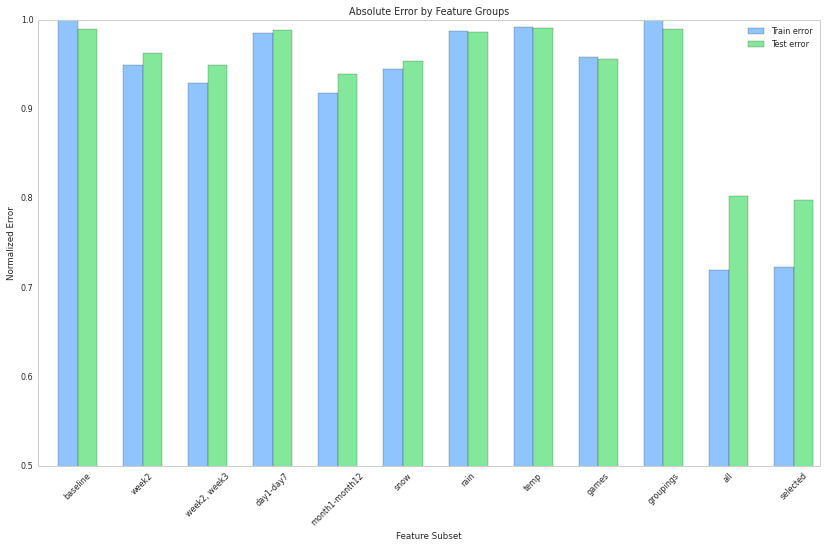

In [187]:
#plot errors for each feature subset
features = grouped_data.label
trainerror = grouped_data.train_error 
testerror = grouped_data.test_error 

#normalize
maxError = max(trainerror)
trainerror = trainerror/maxError
testerror = testerror/maxError

ind = np.arange(len(testerror))
width = .3

fig, ax = plt.subplots(figsize=(14, 8))
#rects1 = ax.bar(ind, score_f, width, color='gray', alpha =.5)
rects2 = ax.bar(ind+width, trainerror, width, color=blue, alpha=.8)
rects3 = ax.bar(ind+2*width, testerror, width, color=green, alpha=.8)

# add some text for labels, title and axes ticks
ax.set_title('Absolute Error by Feature Groups')
ax.set_xlabel('Feature Subset')
ax.set_ylabel('Normalized Error')
ax.set_xticks(ind+2*width)
ax.set_xticklabels(labels, rotation=45)#, ha='right' )
ax.legend( ( rects2[0], rects3[0]), ('Train error', 'Test error') )
plt.ylim(0.5, 1)
plt.grid(False)
plt.savefig('PredictionError.pdf')
plt.show()


The resulting feature matrix included 32 features which were classified into groups for comparison as seen above. The baseline for comparison includes a single feature of historical entries from the previous week. The distribution of the predictive error by station shows the added benefit of each feature subset compared to the baseline. Historical entries, snow data and game data have a significant impact on prediction. The distribution of the prediction error using the optimal selection of features compared to the baseline can be seen below. Overall, stations shift left exhibiting a lower prediction error and the gap between the average error and the baseline is widest in the optimal feature graph.

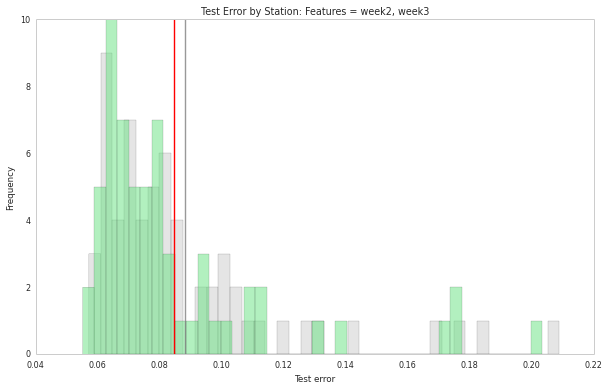

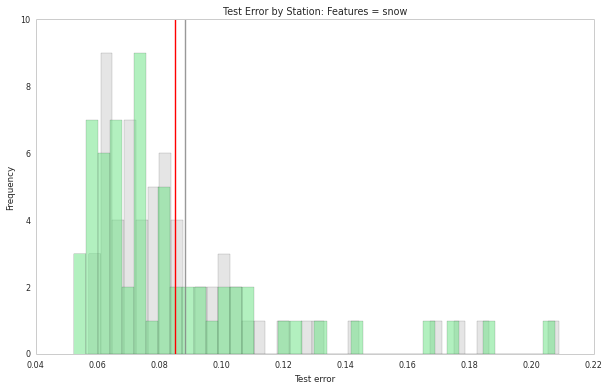

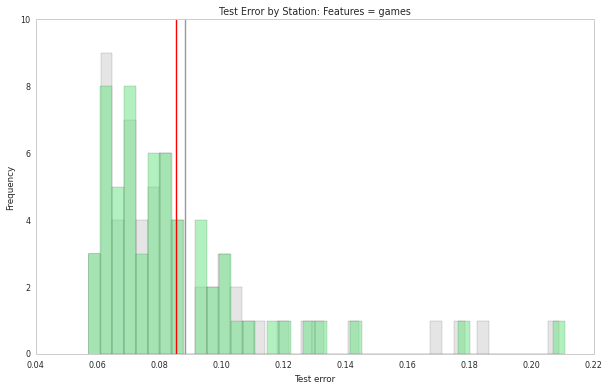

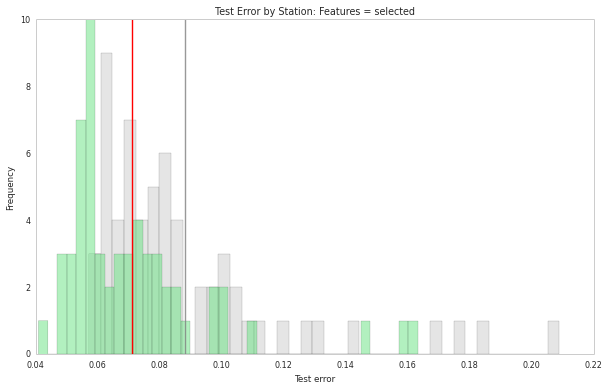

In [44]:
#plot histograms of feature subsets
baseline = model_data[model_data['features'] == target_features[0]]

target_figs = [2, 5, 8,11]

for i in target_figs: #range(1,len(target_features)):
    
    sf = model_data[model_data['features'] == target_features[i]]
    
    # Plot distribution of entries.
    plt.figure(figsize=(10,6))
    plt.hist(baseline.test_error, bins=40, color= '#CCCCCC', alpha=.5)
    plt.hist(sf.test_error.values, bins=40, color= green, alpha=.5)

    plt.vlines(baseline.test_error.mean(),0,10,colors='gray', alpha=.8)
    plt.vlines(sf.test_error.mean(),0,10,colors='r')
    
    plt.title('Test Error by Station: Features = ' + labels[i])
    
    plt.xlabel('Test error')
    plt.ylabel('Frequency')
    plt.ylim([0,10])
    
    plt.grid(False)
    plt.savefig('test_image'+str(i)+'.pdf')
    
    plt.show()


##### Results #####

We found the best feature set to be.

- entries_weeks_ago_1 - entries_weeks_ago_3
- day_of_week_1 - day_of_week_7
- month_1 - month_12
- rain, rain_fall
- snow, snow_fall, snow_accum
- bruins_game, celtics_game, sox_game   
       
Linear Regression using these features:
 train error = 0.066
 test error = 0.07


### Finding the Best Model ###

Now that an optimal feature subset has been determined, the next step is to determine the best model for regression. The initial prediction of entries and comparison with the baseline was performed using a simple linear regression model.  Linear regression fits a linear model with coefficients to minimize the residual sum of squares between the number of entries in the dataset, and the entries predicted by the linear approximation. To attempt to correct for possible correlation in the model terms, a Ridge regression model was also considered. This model imposes a penalty on the size of coefficients with predictions more robust to collinearity and therefore less sensitive to random errors in the recorded entries, producing a smaller variance. Similarly, a Bayesian regression was also considered where the regularization parameter is learned based on the data using uninformative priors over the parameters of the model.

- Ordinary Least Squares
- Ridge Regression
- Random Forest
- Bayesian Regression
- SVM (Support Vector Machines are often the de facto default algorithm to use for a lot of machine learning scenarios. However, based on some preliminary results we decided not to continue testing with SVMs. The time to train was not worth the trivial gain in accuracy - it was taking hours to train a single station!)

In [45]:
best_features = ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'rain', 'rain_fall', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']  
       

In [47]:
"""
Tests a station multiple times by running the prediction method with a different
random state and records the best parameters for each run.

Key arguments:

  station       -- The station to test for.
  predictor     -- The predictor to use (sklearn predictor)
  parameters    -- The parameters for the predictor.
  param_results -- The object to store the parameter results in.
  trials        -- The number of times to run predict (also the number of randomly generated test sets).

"""
def test_params(station, predictor, parameters, param_results, trials = 50):
    for rstate in xrange(trials):
        model, train_error, test_error, train_results, test_results = predict(station, best_features, predictor, parameters, rstate)
        
        param_results = param_results.append({'train_error': train_error, 'test_errors': test_error, 'params': str(model.get_params())}, ignore_index=True)
    
    return param_results

#### Ridge Regression ####

Ridge regression requires a magic number (alpha) that controls the amount of shrinkage (robustness to co-linear features). One approach to finding the best alpha for our environment is to run a grid search with a wide range of alphas on every station. Once the best alpha is determined, it will used as the default alpha for the final ridge regression models.

In [ ]:
param_results = pd.DataFrame()

for locationid in np.unique(data['locationid']):
    station = data[data['locationid'] == locationid]
    
    predictor = linear_model.Ridge()
    parameters = {'alpha': range(0, 101)}
    
    param_results = test_params(station, predictor, parameters, param_results)
    

In [ ]:
grouped = param_results.groupby('params').agg(['mean', 'count'])
grouped['test_errors'].sort('count', ascending=False).to_csv(datadir + '\\ridge-param-results.csv', ignore_index=True)

In [53]:
predictor = linear_model.Ridge()
parameters = {'alpha': [1.0]}
ridge_regression_results = test_all_stations(predictor, parameters, best_features)

In [54]:
print(ridge_regression_results['test_error'].mean())
ridge_regression_results.head()

0.0707656445947


features  locationid  \
0  ['entries_weeks_ago_1', 'entries_weeks_ago_2',...        1002   
1  ['entries_weeks_ago_1', 'entries_weeks_ago_2',...        1004   
2  ['entries_weeks_ago_1', 'entries_weeks_ago_2',...        1005   
3  ['entries_weeks_ago_1', 'entries_weeks_ago_2',...        1006   
4  ['entries_weeks_ago_1', 'entries_weeks_ago_2',...        1007   

            name  test_error  train_error  
0  Andrew Square    0.047562     0.043575  
1     JFK/U Mass    0.096869     0.089985  
2   North Quincy    0.054238     0.049183  
3      Wollaston    0.048181     0.043529  
4  Quincy Center    0.054044     0.049717

In [56]:
ridge_regression_results.to_csv(datadir + '\\ridge-results.csv', ignore_index=True)


##### Random Forest #####

In [16]:
param_results = pd.DataFrame()

for locationid in np.unique(data['locationid']):
    station = data[data['locationid'] == locationid]
    
    predictor = ensemble.RandomForestRegressor()
    parameters = {'n_estimators': range(10, 20)}
    
    param_results = test_params(station, predictor, parameters, param_results)

In [17]:
grouped = param_results.groupby('params').agg(['mean', 'count'])
grouped['test_errors'].sort('count', ascending=False).head()

mean  \
params                                                                                                                                                                                                                                                                                                           
{'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'min_density': None, 'compute_importances': None, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 19, 'min_samples_split': 2, 'random_state': None, 'criterion': 'mse', 'max_features': 'auto', 'max_depth': None}  0.075936   
{'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'min_density': None, 'compute_importances': None, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 18, 'min_samples_split': 2, 'random_state': None, 'criterion': 'mse', 'max_features': 'auto', 'max_depth': None}  0.075987   
{'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'min_density': None, 'compute_importances': None, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 17, 'min_samples_split': 2, 'random_state': None, 'criterion': 'mse', 'max_features': 'auto', 'max_depth': None}  0.077465   
{'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'min_density': None, 'compute_importances': None, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 16, 'min_samples_split': 2, 'random_state': None, 'criterion': 'mse', 'max_features': 'auto', 'max_depth': None}  0.077740   
{'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'min_density': None, 'compute_importances': None, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 15, 'min_samples_split': 2, 'random_state': None, 'criterion': 'mse', 'max_features': 'auto', 'max_depth': None}  0.074958   

                                                                                                                                                                                                                                                                                                      count  
params                                                                                                                                                                                                                                                                                                       
{'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'min_density': None, 'compute_importances': None, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 19, 'min_samples_split': 2, 'random_state': None, 'criterion': 'mse', 'max_features': 'auto', 'max_depth': None}    446  
{'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'min_density': None, 'compute_importances': None, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 18, 'min_samples_split': 2, 'random_state': None, 'criterion': 'mse', 'max_features': 'auto', 'max_depth': None}    427  
{'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'min_density': None, 'compute_importances': None, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 17, 'min_samples_split': 2, 'random_state': None, 'criterion': 'mse', 'max_features': 'auto', 'max_depth': None}    395  
{'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'min_density': None, 'compute_importances': None, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 16, 'min_samples_split': 2, 'random_state': None, 'criterion': 'mse', 'max_features': 'auto', 'max_depth': None}    375  
{'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'min_density': None, 'compute_importances': None, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 15, 'min_samples_split': 2, 'random_state': None, 'criterion': 'mse', 'max_features': 'auto', 'max_depth': None}    350

In [18]:
grouped = param_results.groupby('params').agg(['mean', 'count'])
grouped['test_errors'].sort('count', ascending=False).to_csv("../../results/prediction/randomforrest-param-results.csv", ignore_index=True)

In [57]:
predictor = ensemble.RandomForestRegressor()
parameters = {'n_estimators': [100]}
rf_regression_results = test_all_stations(predictor, parameters, best_features)

In [58]:
print(rf_regression_results['test_error'].mean())
rf_regression_results.head()

0.069377774586


features  locationid  \
0  ['entries_weeks_ago_1', 'entries_weeks_ago_2',...        1002   
1  ['entries_weeks_ago_1', 'entries_weeks_ago_2',...        1004   
2  ['entries_weeks_ago_1', 'entries_weeks_ago_2',...        1005   
3  ['entries_weeks_ago_1', 'entries_weeks_ago_2',...        1006   
4  ['entries_weeks_ago_1', 'entries_weeks_ago_2',...        1007   

            name  test_error  train_error  
0  Andrew Square    0.050316     0.018804  
1     JFK/U Mass    0.092390     0.034765  
2   North Quincy    0.055001     0.020197  
3      Wollaston    0.048454     0.017865  
4  Quincy Center    0.055453     0.020878

In [59]:
rf_regression_results.to_csv(datadir + '\\randomforest-results.csv', ignore_index=True)


##### Ensemble Averaging Method #####


In [118]:
#get results from all individual learners
bays_regression_results = pd.read_csv(datadir + '\\bayesian-results-v1.csv', low_memory=False)
rf_regression_results   = pd.read_csv(datadir + '\\randomforest-results.csv', low_memory=False)
ridge_regression_results= pd.read_csv(datadir + '\\ridge-results.csv', low_memory=False)


In [188]:
#combine results
all_results = pd.merge(ridge_regression_results, rf_regression_results, how='left', on='locationid', suffixes=('_r', '_rf'))
all_results = pd.merge(all_results, bays_regression_results, how='left', on='locationid', suffixes=('', '_b'))

all_results = all_results[[u'locationid', u'name', u'test_error_r',  u'test_error_rf', u'blr', u'ols']]
all_results.columns = [u'locationid', u'name', u'ridge',  u'random_forest', u'bayesian', u'ols']

all_results['MinError'] = all_results.ix[:,2:].min(axis=1)
all_results['MinMethod'] = all_results.ix[:,2:].idxmin(axis=1)

all_results[['name', 'MinMethod']].groupby('MinMethod').count()

name
MinMethod          
bayesian         21
random_forest    18
ridge            22

Each regression model was tuned and applied to every rail station. The average of 50 trials was obtained calculating the error proportionally to the ridership volume of the station. Out of the 61 stations being considered, about one third performed better using each of the Ridge, Random Forest, and Bayesian regression models respectively. An ensemble averaging method using a combination of these learners was employed to improve predictions. The results are summarized below:


In [190]:
print 'Ordinary Least Squares error:', all_results['ols'].mean() 
print 'Ridge Regression error:      ', all_results['ridge'].mean() 
print 'Random Forest error:         ', all_results['random_forest'].mean() 
print 'Bayesian Regression error:   ', all_results['bayesian'].mean() 
print 'Ensemble Method error:       ', all_results['MinError'].mean() 

Ordinary Least Squares error: 0.0765255625338
Ridge Regression error:       0.0707656445947
Random Forest error:          0.069377774586
Bayesian Regression error:    0.0711094617881
Ensemble Method error:        0.0675574346401


###Prediction Results and Outliers####

In [197]:
def plotEntries(stationid, line, name):
    selected_station = gatecounts[gatecounts['locationid'] == stationid]
    selected_station = selected_station[['service_day','entries','exits']].groupby('service_day').agg(np.sum)

    plt.figure(figsize=(12,8))
    plt.plot(selected_station.index,selected_station.entries, color=line)
    plt.title('Entries by Date: ' + name)
    plt.xlabel('Date') ; plt.ylabel('Entries')
    plt.show()

####Stations with very high predictive accuracy (>95%)

In [199]:
#get best stations and group them by line
min_stations = pd.merge(all_results[all_results['MinError'] <= 0.06], stations, how='left', left_on='locationid', right_on='stationid')
min_stations[['name_x', 'line_1']].groupby('line_1').count()


name_x
line_1        
Blue         6
Green        2
Orange       8
Red         14

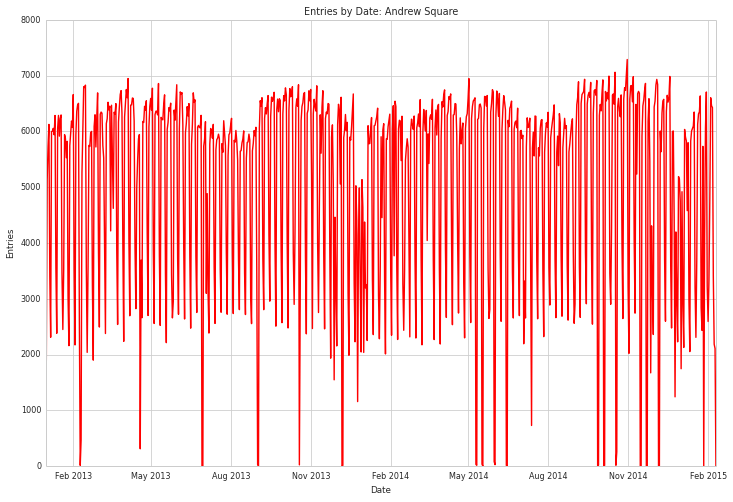

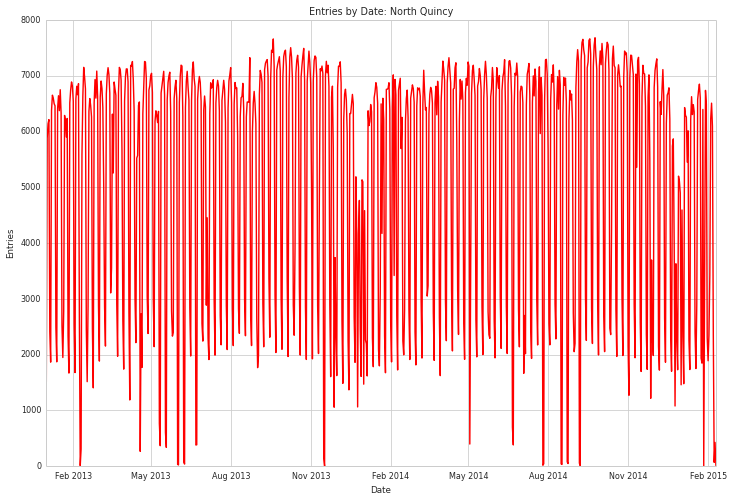

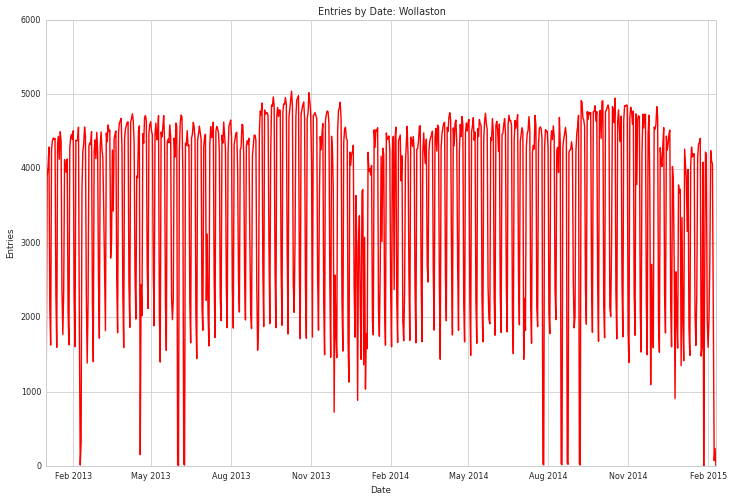

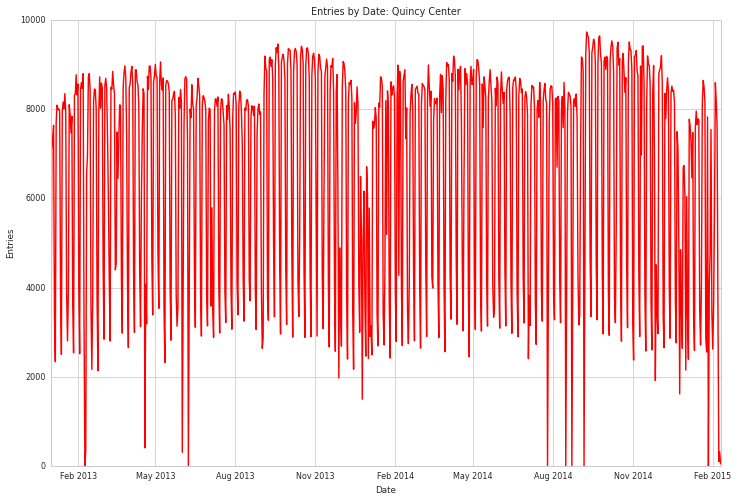

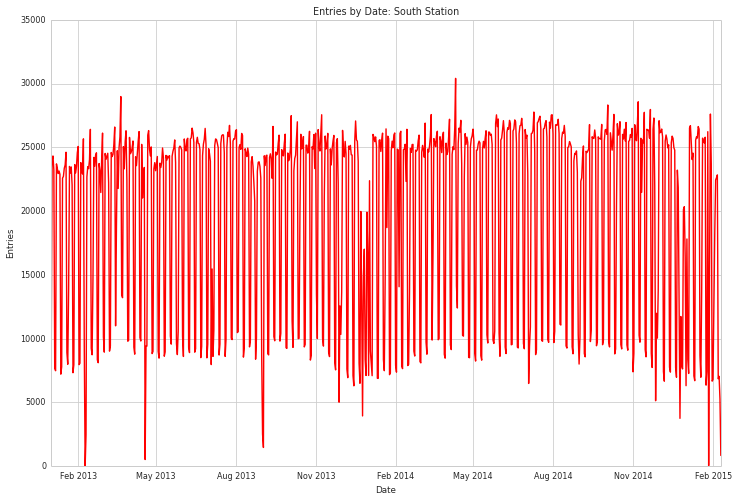

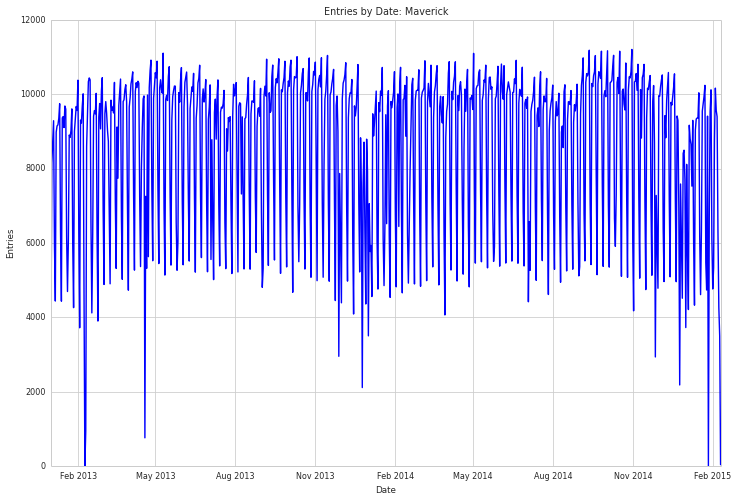

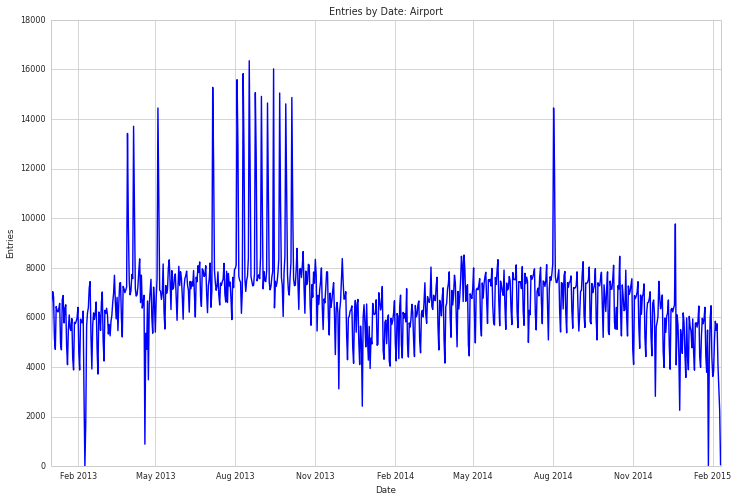

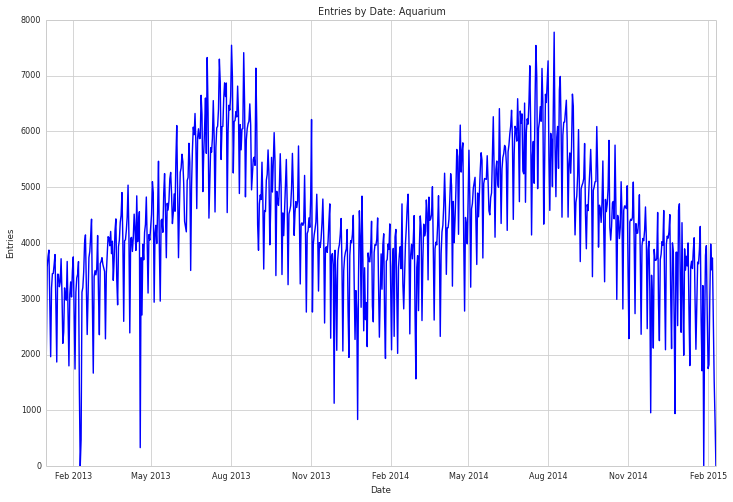

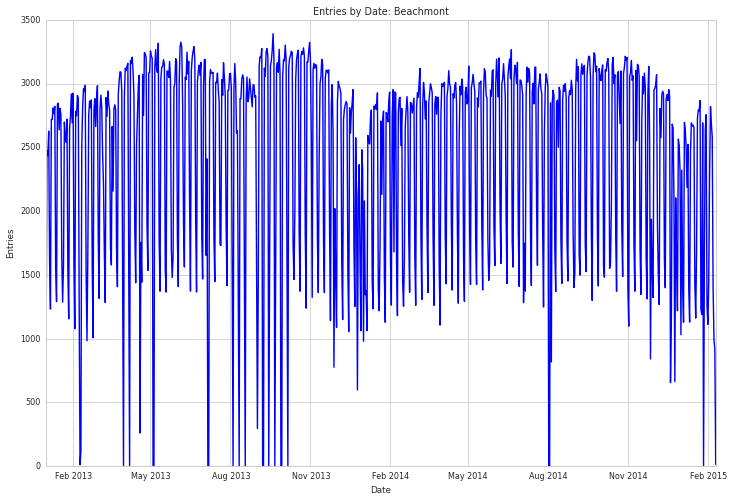

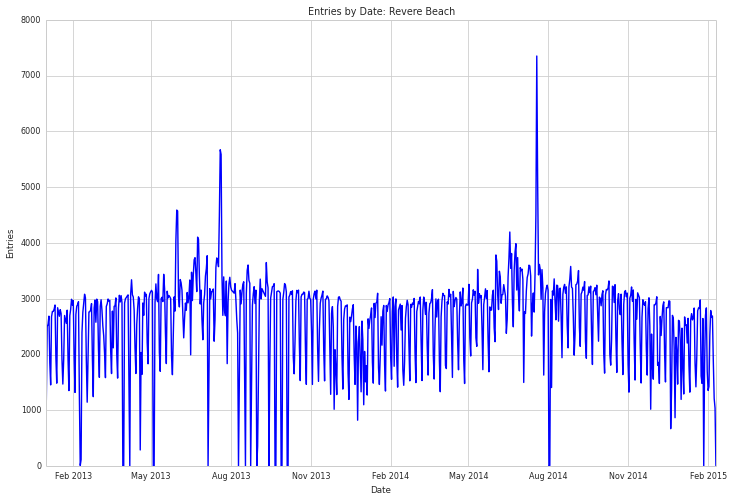

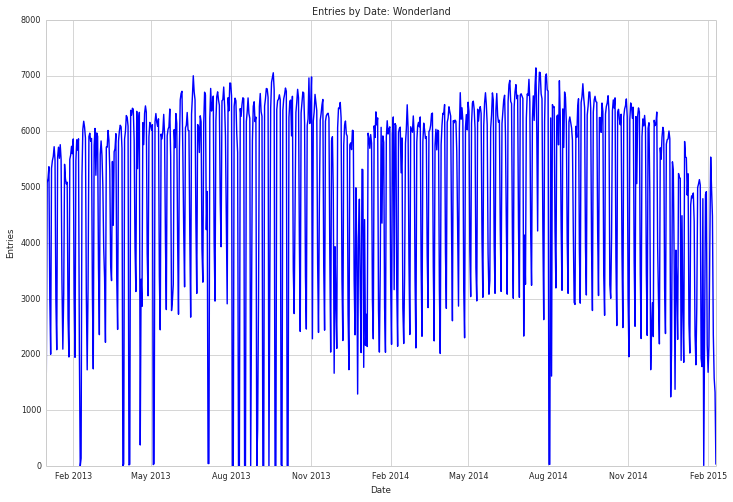

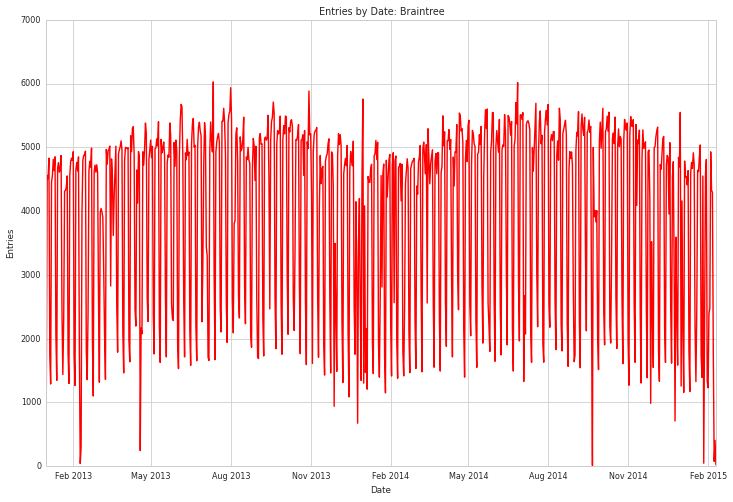

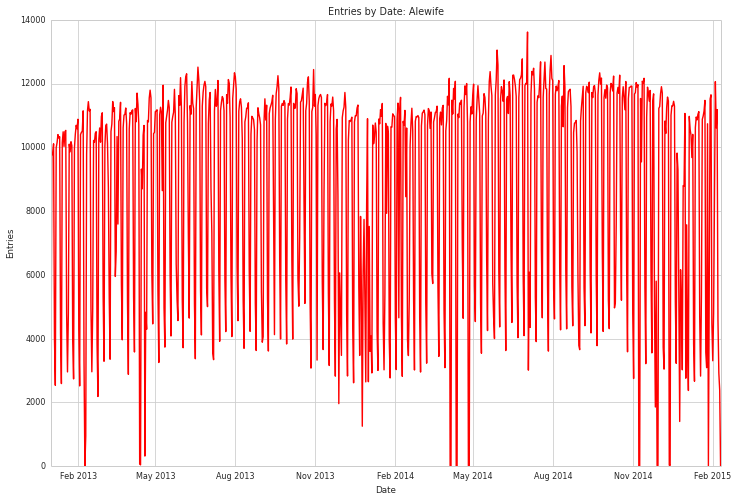

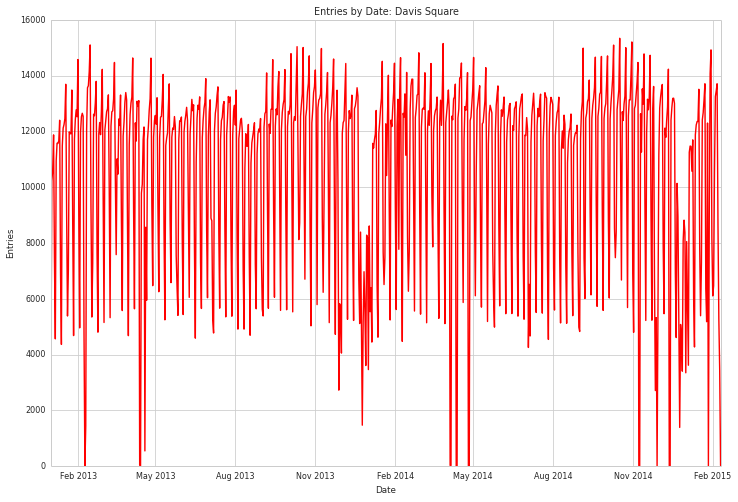

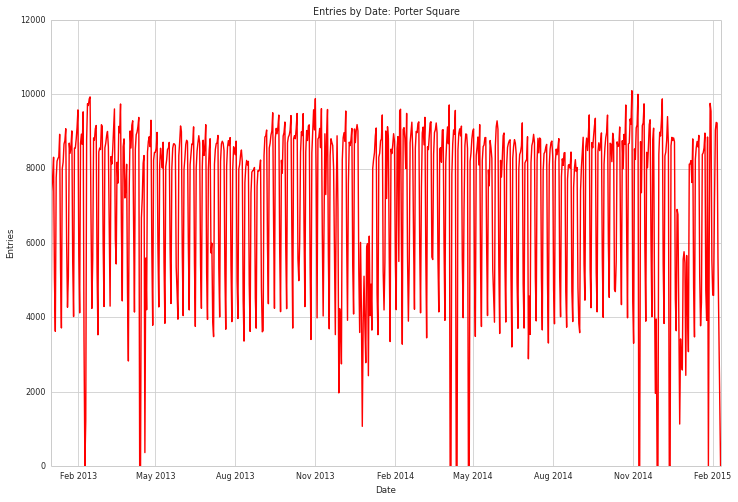

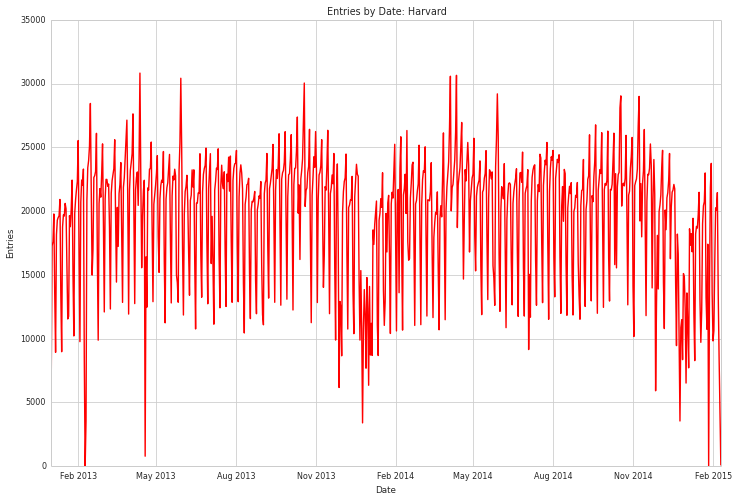

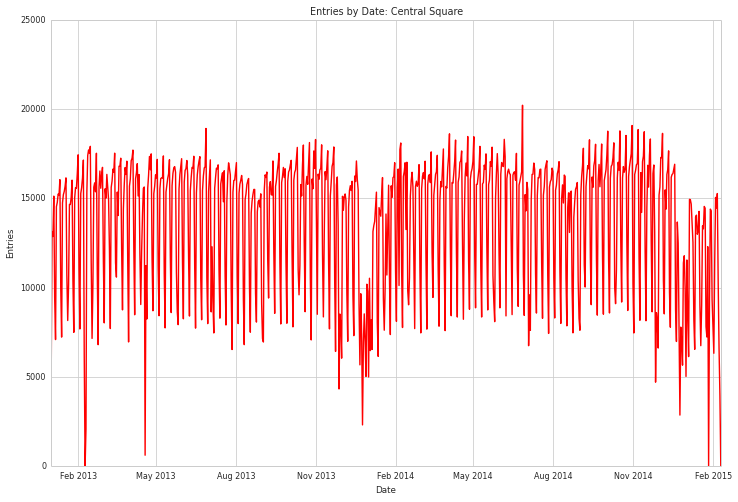

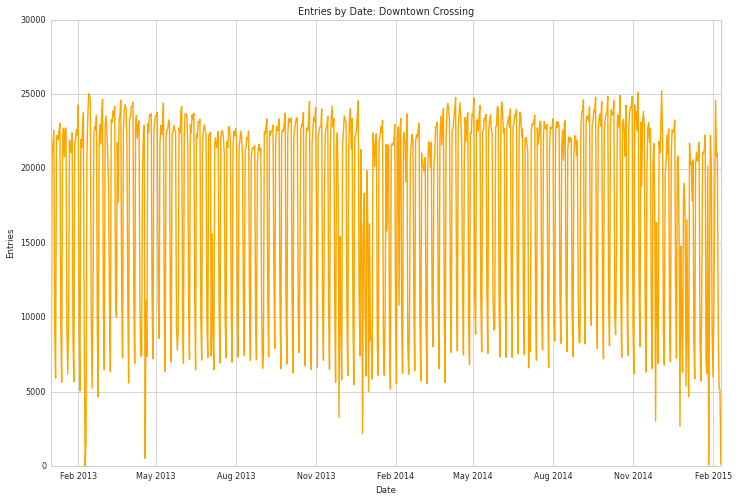

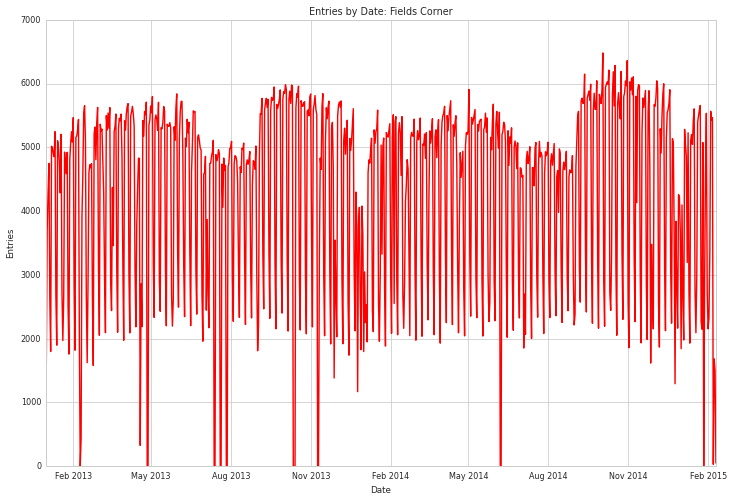

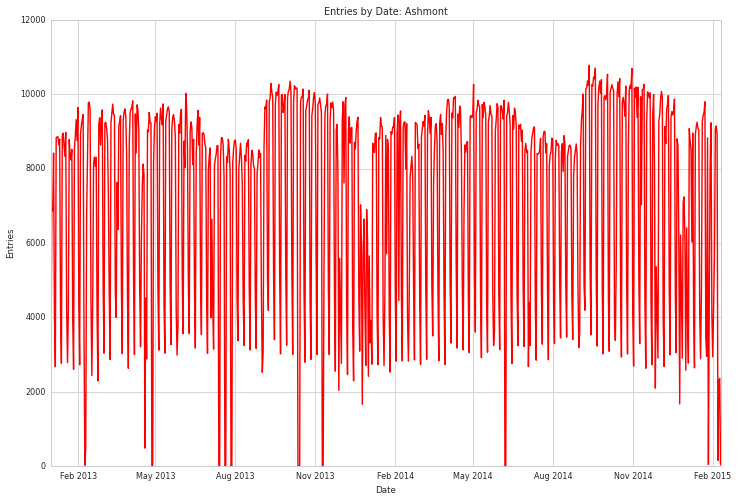

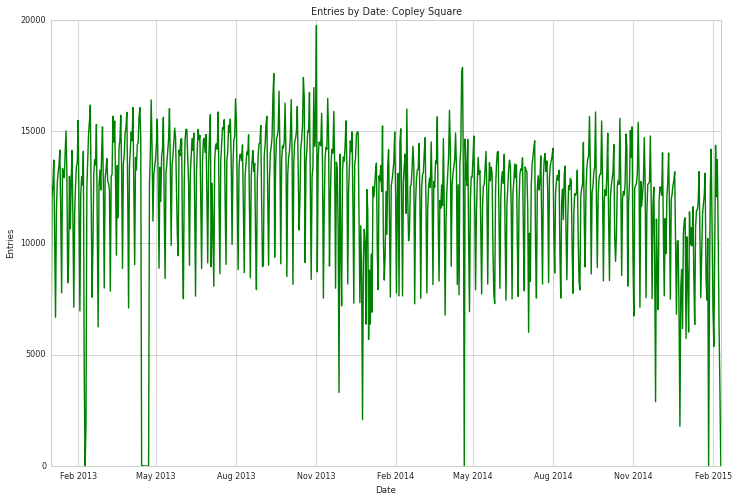

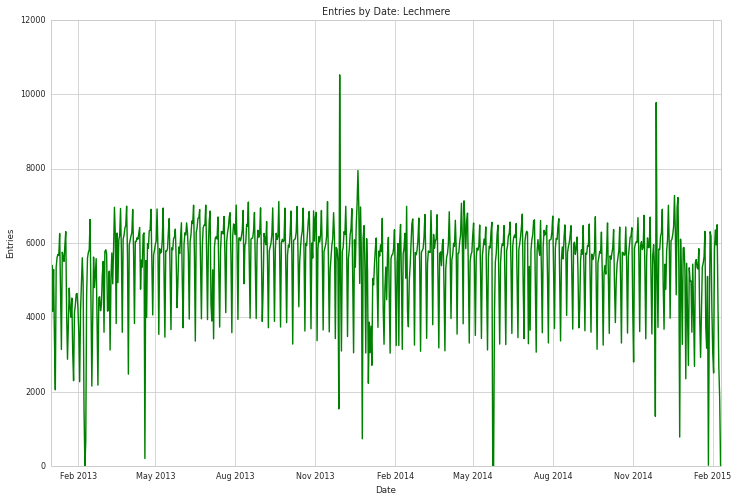

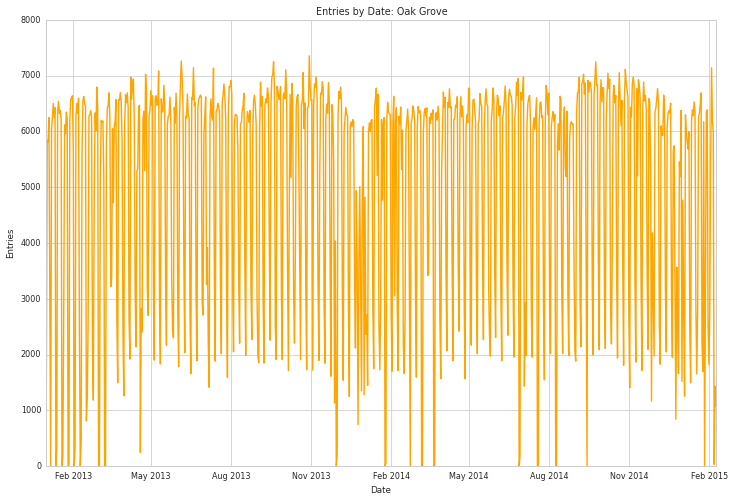

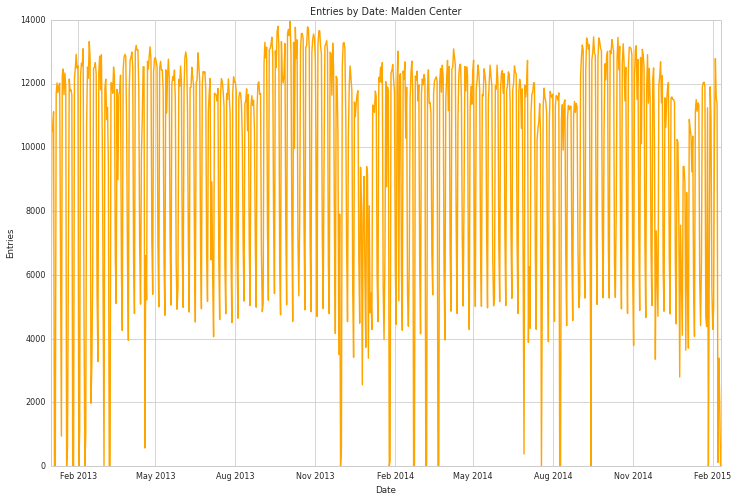

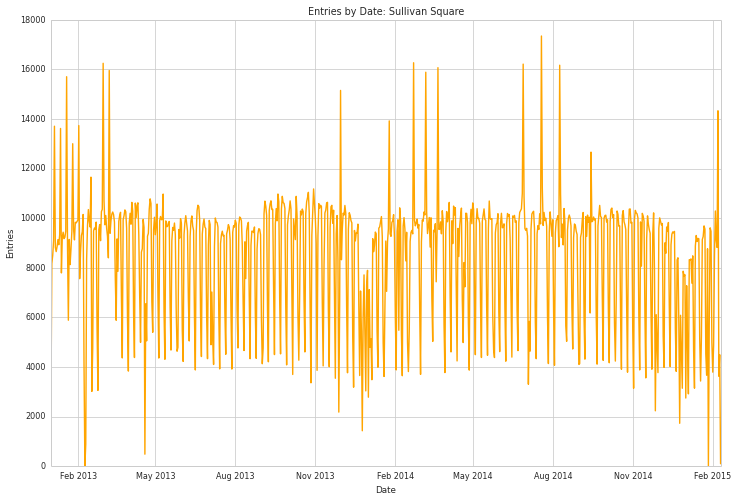

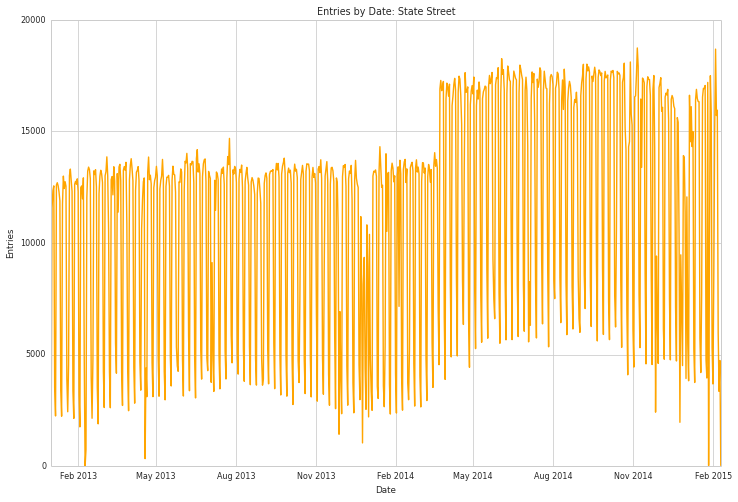

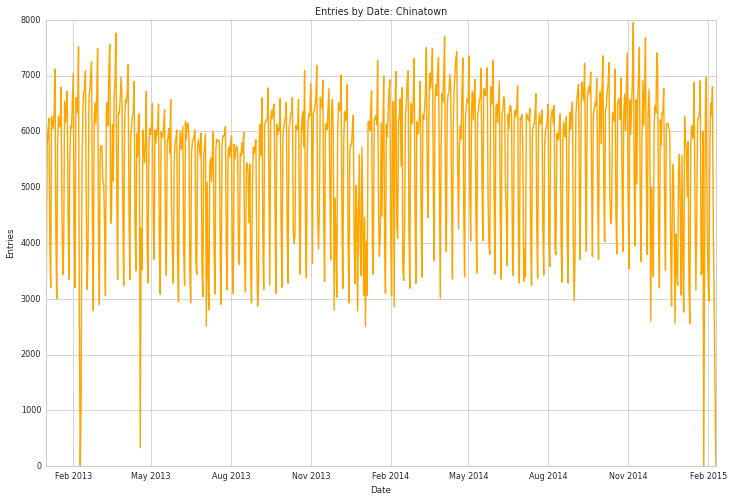

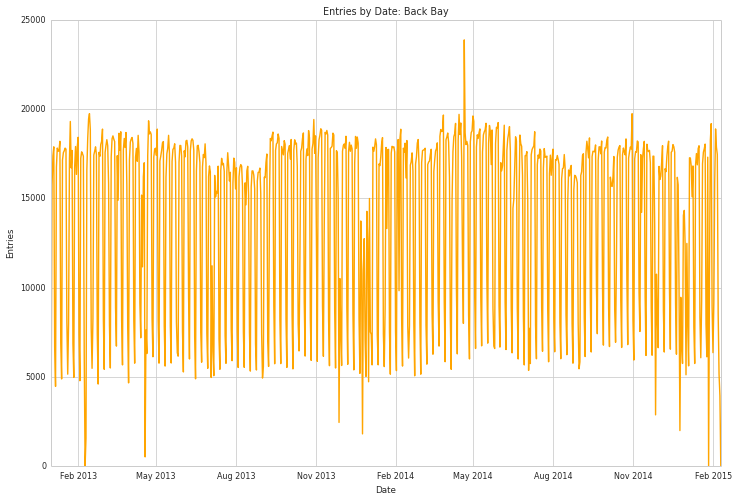

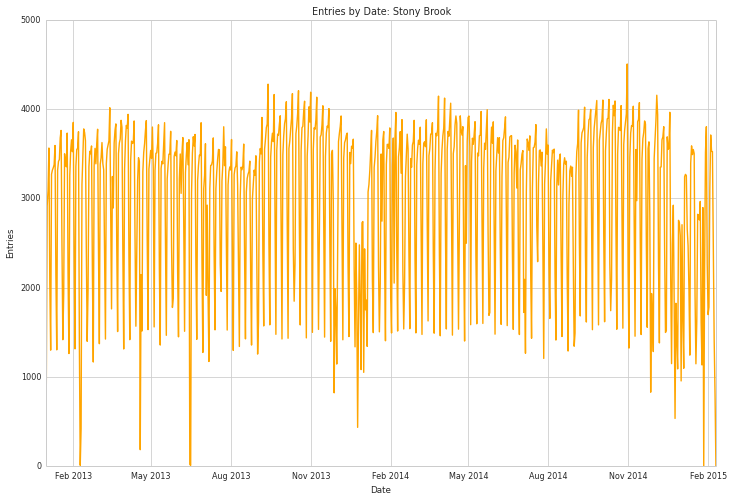

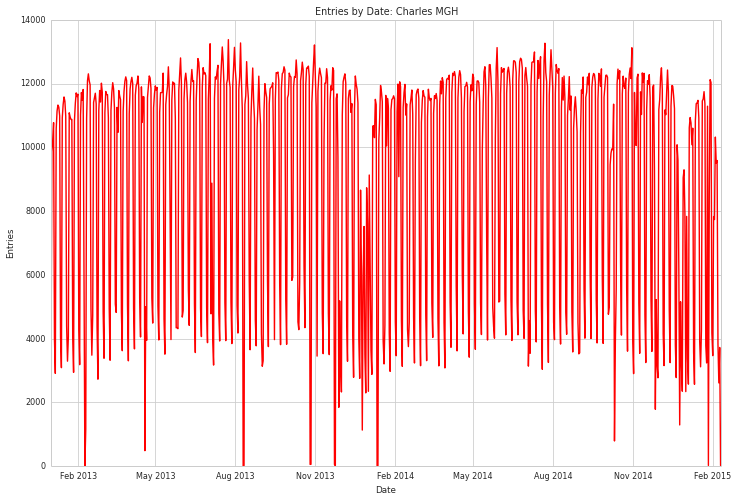

In [201]:
for station, line, name in zip(min_stations.locationid, min_stations.line_1, min_stations.name_x):
    plotEntries(station, line, name)

####Stations with lowest predictive accuracy (<90%) - Outliers

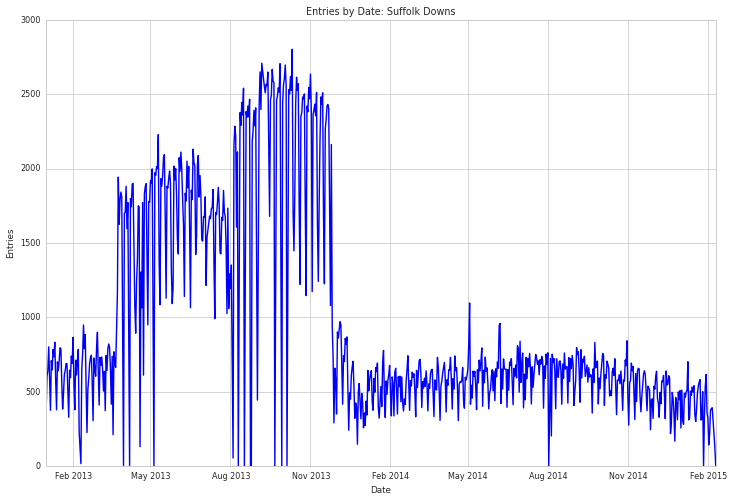

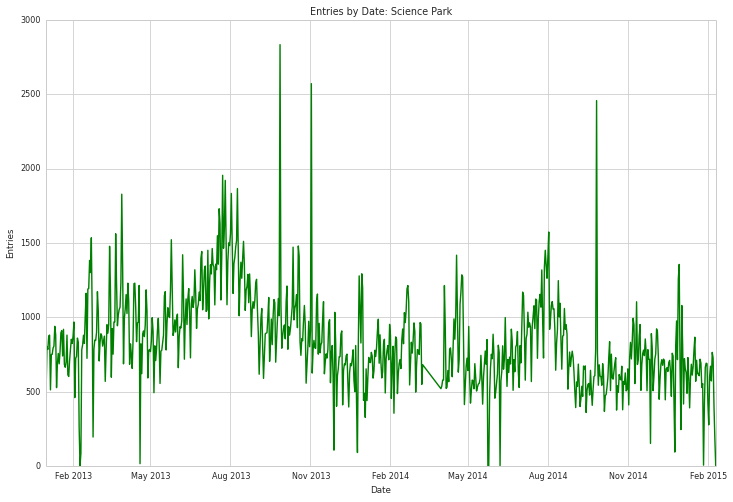

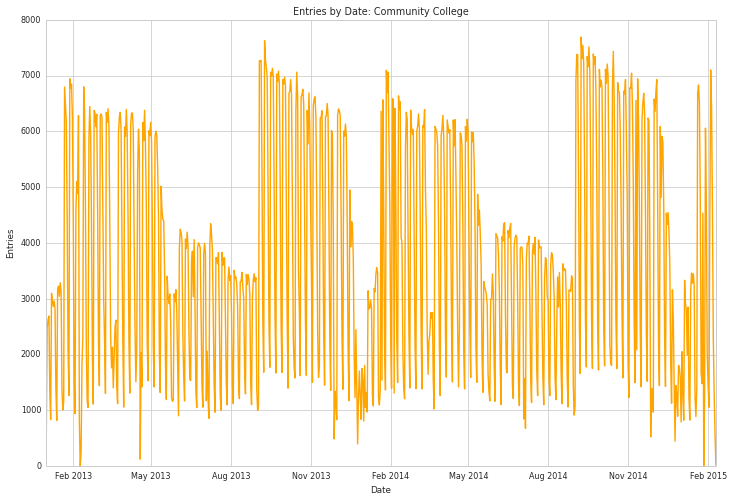

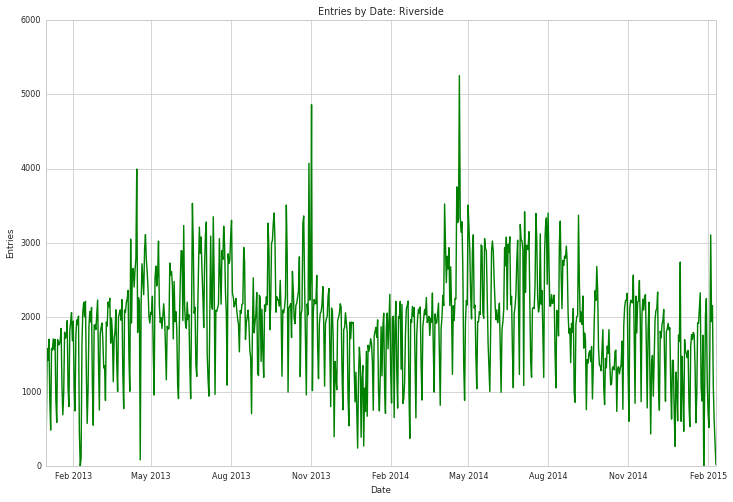

In [198]:
#Outliers
max_stations = pd.merge(all_results[all_results['MinError'] >= 0.1], stations, how='left', left_on='locationid', right_on='stationid')

for station, line, name in zip(max_stations.locationid, max_stations.line_1, max_stations.name_x):
    plotEntries(station, line, name)
    

## Conclusion ##

- Feature engineering: The best feature subset obtained includes historical entries, day/month, snow data, game data

- Model selection: An ensemble averaging method using a combination of learners (Linear, Ridge, Random Forest, Bayesian regressors) was employed to improve predictions. The best predictive results are achieved with the ensemble method resulting in 94% predictive accuracy.

- Overall, 30 stations have a very high predictive accuracy (>95%). Most of these higher ranking stations are on the red and orange line with a station count of 14 and 8, respectively. On the other hand, stations with the lowest predictive accuracy (<90%) are Science Park, Community College, Suffolk Downs, and Riverside.